In [1]:
from math import ceil, floor, pi, log2
import numpy as np
from matplotlib import pyplot as plt

import ffmpegio as ff

from straight_pitch.utils import decimate
from straight_pitch.straight_pitch import (
    zinitializeParameters,
    cleaninglownoise_filter,
    cleaninglownoise,
)
from straight_pitch.fixpF0VexMltpBG4 import (
    zwvlt2ifq,
    zsmoothmapB,
    zifq2gpm2,
    zfixpfreq3,
    znrmlcf2,
)

two_pi = 2 * pi

### Load sample audio at 16 kS/s

In [2]:
fs, xin = ff.audio.read("test/vaiueo2d.wav", sample_fmt="dbl", ac=1, ar=16000)
xin = xin[:, 0]  # make it 1D

# Fixed point analysis of instantaneous fundamental frequency

Load the relevant STRAIGHT parameters:

In [3]:
prm = zinitializeParameters()

# f0 search channels
f0floor = prm["F0searchLowerBound"]
f0ceil = prm["F0searchUpperBound"]
nvo = prm["NofChannelsInOctave"]
nvc = ceil(log2(f0ceil / f0floor) * nvo)  # number of channels
Fxx = f0floor * 2 ** (np.arange(nvc) / nvo) # channel center frequencies in Hz

mu: float = prm["IFWindowStretch"]
smp: float = prm["IFsmoothingLengthRelToFc"]
minm: float = prm["IFminimumSmoothingLength"]
pc: float = prm["IFexponentForNonlinearSum"]
nc: int = prm["IFnumberOfHarmonicForInitialEstimate"]
shiftm: float = prm["F0frameUpdateInterval"] * 1e-3

Convert parameters from contnuous-time to discrete-time domain

In [4]:
# frequency bin conversions
fxx = Fxx / fs  # normalized frequency
omegaxx = two_pi * fxx.reshape(-1, 1)  # in radians/sample

# decimate signal so the signal at `f0ceil` Hz gets ~6 samples
dn = max(1, floor(1 / (fxx[-1] * 6.3)))  # for higher-harmonic analyses
dn1 = dn * 3  # for the 1st harmonic analysis
fs1 = fs / dn1

# output downsampling factor so the frames are separated by approximately `shiftm` seconds
frame_step = shiftm * fs
frame_step = round(frame_step / dn)

## STEP 1: Remove DC/near-DC spectral content

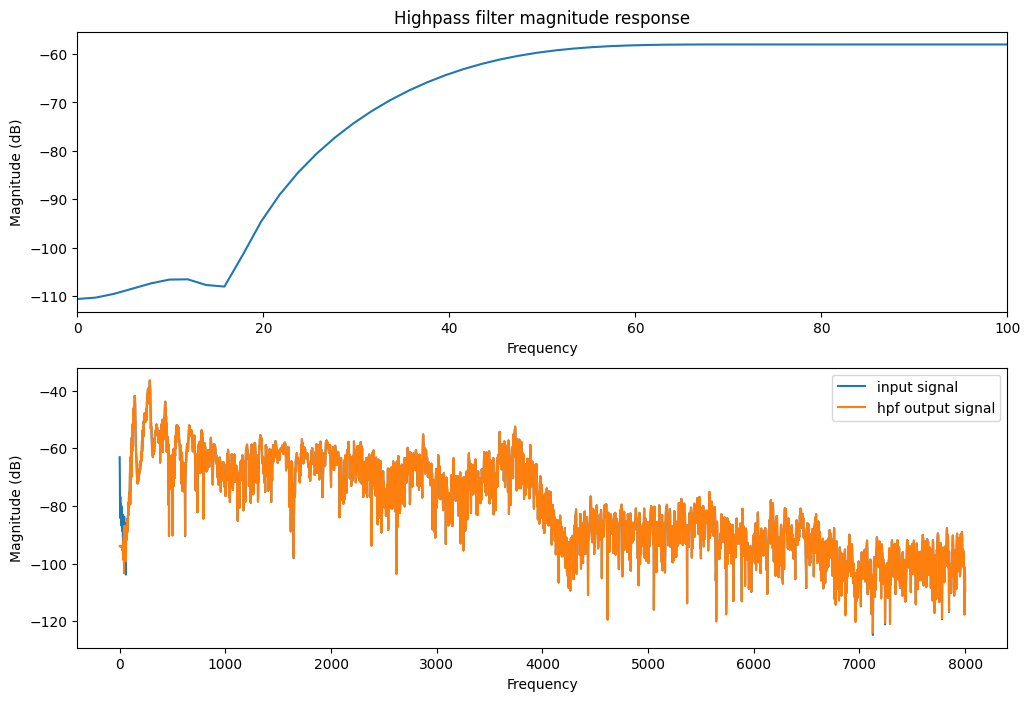

In [5]:
b = cleaninglownoise_filter(fs, f0floor)[0] # to plot frequency response

x = cleaninglownoise(xin, fs, f0floor)

plt.subplots(2, 1, figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.magnitude_spectrum(b, fs, scale="dB", sides="onesided", pad_to=8096)
plt.xlim([0, 100])
plt.title("Highpass filter magnitude response")
plt.subplot(2, 1, 2)
plt.magnitude_spectrum(xin, fs, pad_to=8192, label="input signal", scale="dB")
plt.magnitude_spectrum(x, fs, pad_to=8192, label="hpf output signal", scale="dB")
_ = plt.legend()

## STEP 2: Run the filterbank to isolate frequency content per channel

By default, it conducts only the 1st harmonic analysis

c:\Users\tikum\Documents\Research\python-STRAIGHT-pitch\.venv\Lib\site-packages\matplotlib\axes\_axes.py:7748: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)


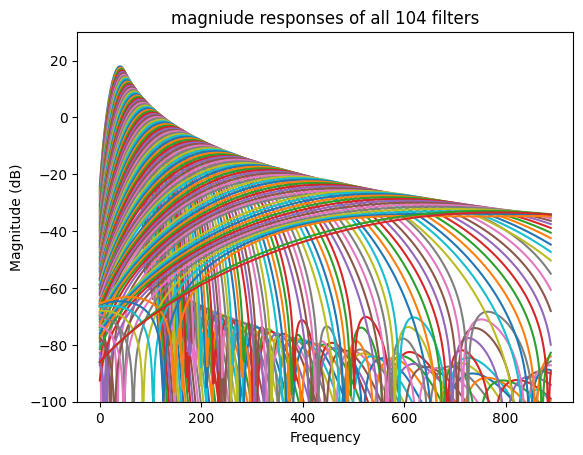

In [6]:
# process
f0 = fxx * dn1
f0_eta = f0 * mu
nw = np.ceil(3.5 / f0_eta).astype(int)
nh = np.ceil(1 / f0_eta).astype(int)
W, nw = cspb_filters(f0, f0_eta, nw, nh, 1)

for w in W:
    plt.magnitude_spectrum(w, fs1, pad_to=1024, sides="onesided", scale="dB")
# plt.xscale('log')
plt.ylim([-100,30])
_=plt.title(f'magniude responses of all {W.shape[0]} filters')

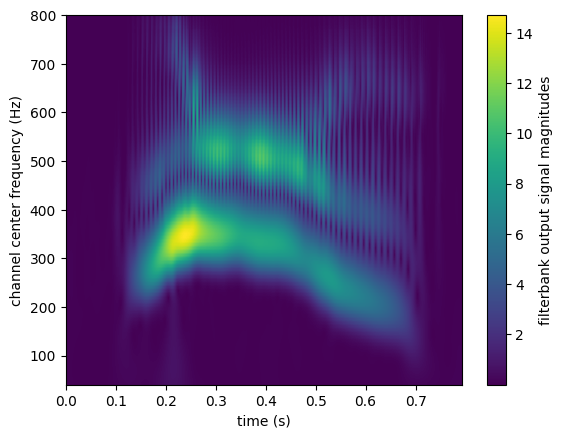

In [7]:
xd1 = decimate(x, dn1)
pm1 = multanalytFineCSPB(xd1, fxx * dn1, mu, 1)
pm1abs = np.abs(pm1)
plt.imshow(
    pm1abs, origin="lower", aspect="auto", extent=[0, pm1.shape[1]/fs1, f0floor, f0ceil]
)
plt.colorbar(label='filterbank output signal magnitudes')
plt.xlabel('time (s)')
_=plt.ylabel('channel center frequency (Hz)')

## STEP 3: Estimate instantaneous frequencies of all channels from the phases of the filterbank outputs

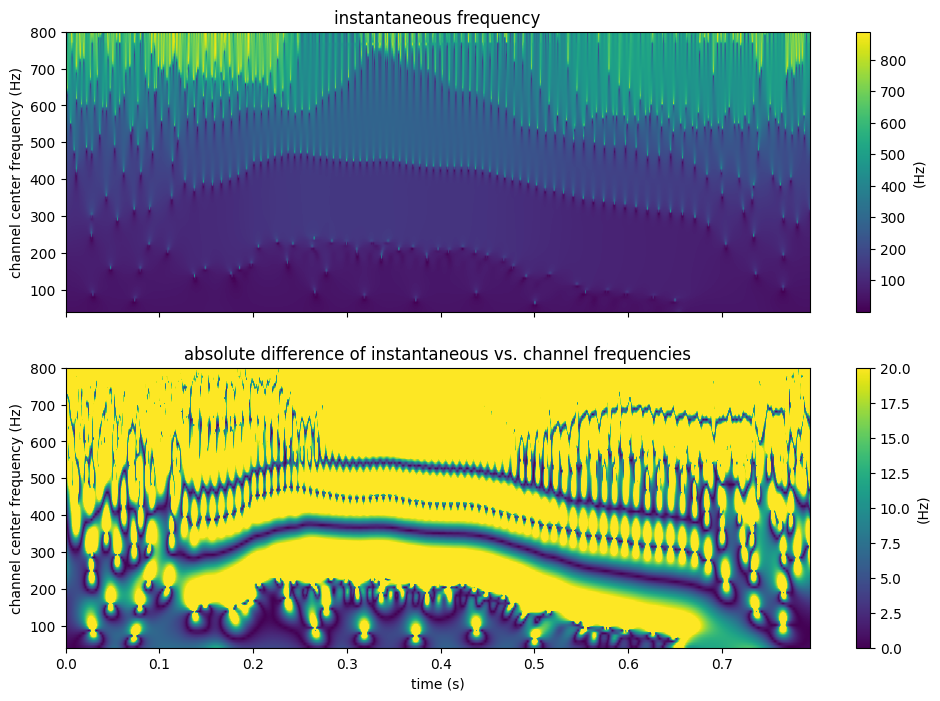

In [8]:
pif1 = zwvlt2ifq(pm1) / dn1  # in radian/samples

imshow_args = dict(
    origin="lower", aspect="auto", extent=[0, pm1.shape[1] / fs1, f0floor, f0ceil]
)

plt.subplots(2, 1, figsize=[12, 8], sharex=True)
plt.subplot(2, 1, 1)
plt.imshow(pif1 * fs / two_pi, **imshow_args)
plt.title("instantaneous frequency")
plt.colorbar(label="(Hz)")
plt.ylabel("channel center frequency (Hz)")
plt.subplot(2, 1, 2)
plt.imshow(
    np.abs(pif1 * fs / two_pi - Fxx.reshape(-1, 1)), **imshow_args, vmin=0, vmax=20
)
plt.colorbar(label="(Hz)")
plt.title("absolute difference of instantaneous vs. channel frequencies")
plt.xlabel("time (s)")
_ = plt.ylabel("channel center frequency (Hz)")

## Step 4: Estimate relative noise energy

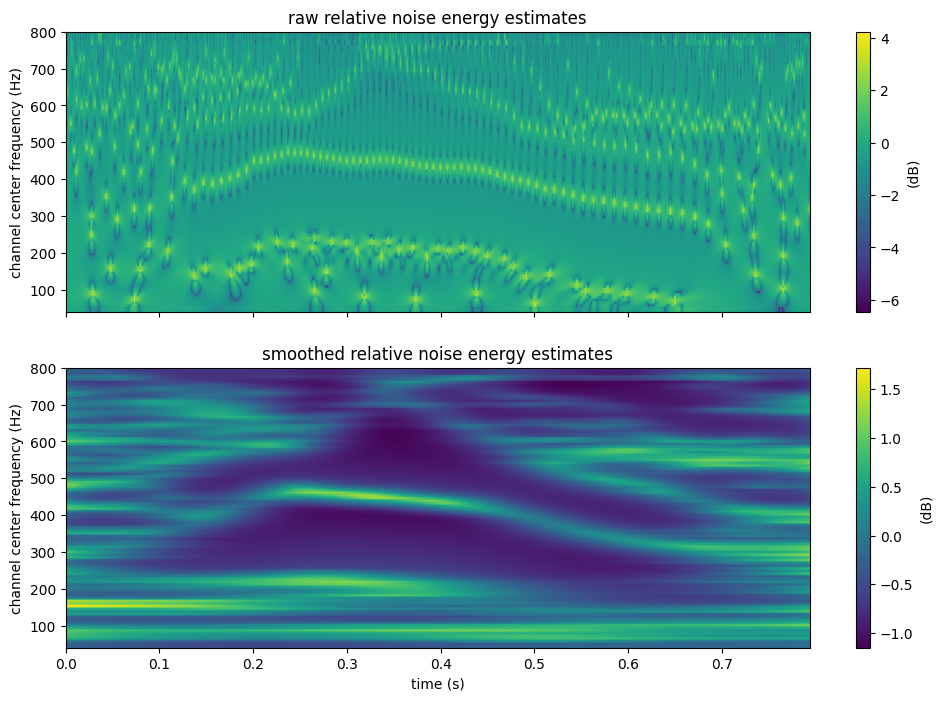

In [9]:
# ~ dwc(t,lambda)/dlambda for eq (10)
slp = zifq2gpm2(pif1, omegaxx)

# d2wc/dt dlambda for eq (10)
nn, mm = pif1.shape
dpif = np.empty_like(pif1)
dpif[:, :-1] = (pif1[:, 1:] - pif1[:, :-1]) / dn1
dpif[:, -1] = dpif[:, -1]
dslp = zifq2gpm2(dpif, omegaxx)

mmp = np.empty_like(dslp)
c1, c2 = znrmlcf2()
mmp = slp**2 / c1 + dslp**2 / c2.reshape(-1, 1)  # sig2_tilde - eq(10)

# smooth the relative noise energy map eq (11)
smap = zsmoothmapB(mmp, fxx, smp, minm * 1e-3 * fs, 0.4) if smp != 0 else mmp

plt.subplots(2,1,figsize=[12,8],sharex=True)
plt.subplot(2,1,1)
plt.imshow(np.log10(mmp), **imshow_args)
plt.title("raw relative noise energy estimates")
plt.colorbar(label="(dB)")
plt.ylabel("channel center frequency (Hz)")
plt.subplot(2,1,2)
plt.imshow(np.log10(smap), **imshow_args)
plt.colorbar(label="(dB)")
plt.title("smoothed relative noise energy estimates")
plt.xlabel("time (s)")
_ = plt.ylabel("channel center frequency (Hz)")


## Step 5: Selection of instantaneous frequency candidates

7


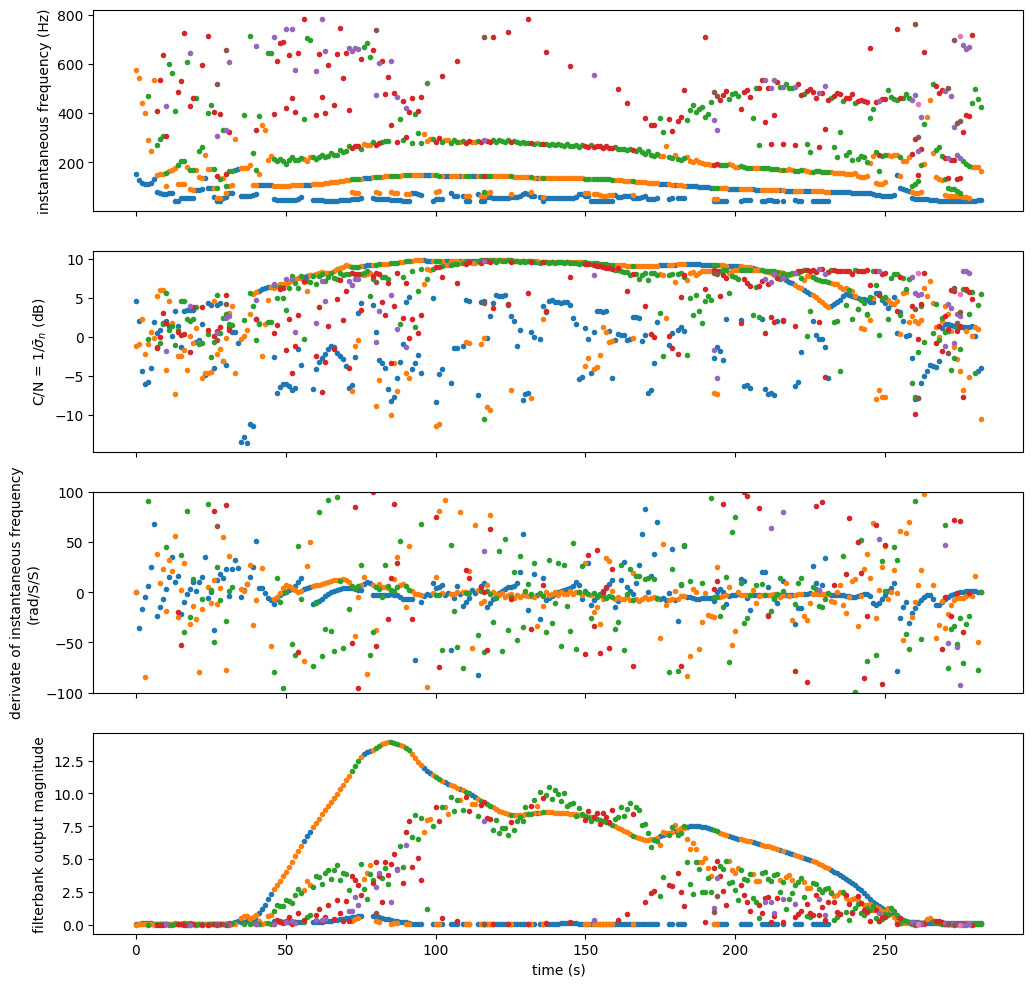

In [10]:
m = slice(None, None, frame_step)
res = [
    zfixpfreq3(omegaxx.reshape(-1), *args)
    for args in zip(pif1[:, m].T, smap[:, m].T, dpif[:, m].T / 2 / pi, pm1abs[:, m].T)
]
nfmax = max(x[0].shape[0] for x in res)
print(nfmax)

fixpp, fixvv, fixdf, fixav = np.stack(
    [np.pad(v, [(0, 0), (0, nfmax - v.shape[1])], constant_values=np.nan) for v in res],
    -1,
)

plt.subplots(4, 1, figsize=[12, 12], sharex=True)
plt.subplot(4, 1, 1)
plt.plot(fixpp.T * fs / two_pi, ".")
plt.ylabel("instantaneous frequency (Hz)")
plt.subplot(4, 1, 2)
plt.plot(-10 * np.log10(fixvv.T), ".")
plt.ylabel("C/N = $1/\\bar\\sigma_n$ (dB)")
plt.subplot(4, 1, 3)
plt.plot(fixdf.T * fs / two_pi * fs1, ".")
plt.ylabel("derivate of instantaneous frequency\n(rad/S/S)")
plt.ylim(-100,100)
plt.subplot(4, 1, 4)
plt.plot(fixav.T, ".")
plt.ylabel("filterbank output magnitude")
_ = plt.xlabel("time (s)")